Generate encoded vectors for both query and artist aggregrate images

In [ ]:
import read_rijksdata
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pylab as plt
import matplotlib as mpl
MIN_NUM_ARTWORK = 500


In [ ]:
# LOAD IMAGE AND LABELS HERE
# replace for your path here!
img_folder = '/Users/erebor/Downloads/out_img'

images, labels_onehot, labels, names, = read_rijksdata.load_data(MIN_NUM_ARTWORK=MIN_NUM_ARTWORK,
                                                 img_folder = img_folder,
                                                 labels_file ='labels.txt',
                                                 names_file = 'names.txt')

 |███████████████████████████████████████-| 112038/112039 

Dataset loaded!
images shape:	 (19007, 56, 56, 3)
labels shape:	 (19007,)
labels (one-hot):	 (19007, 21)
names shape:	 (19007, 1)


In [ ]:
classes = len(list(set(labels)))
print('\n# of unique artists:',classes)

counts = pd.DataFrame(labels).value_counts()
print('Min # of artworks for all artists:',min(counts))
print('Min # of artworks specified:',MIN_NUM_ARTWORK)


# of unique artists: 21
Min # of artworks for all artists: 517
Min # of artworks specified: 500


In [ ]:
# LOAD PRE-TRAINED ENCODER
# get base pre-trained model first
# more models are available here: https://www.tensorflow.org/api_docs/python/tf/keras/applications

# define hyperparameters
# define image size 
D = 100
input_shape = (224,224,3)

# define number of classes
# ****THIS sets the number of dimensions of the encoded vector ("D") in Mark's email***
# we'll probably want adjust this to be smaller or larger (depending on training results)
# for now, classes are just the number of unique artist
enet_kwargs = {'include_top':False,
               'weights':'imagenet',
               'input_tensor':None,
               'input_shape':input_shape,
               'pooling':None,
               'classes':D,
               'classifier_activation':'sigmoid'}
enet_base = tf.keras.applications.efficientnet.EfficientNetB7(**enet_kwargs)

# set that the encoder DOES NOT train on the images
enet_base.trainable = False

# set pre-trained model as base
enet = tf.keras.models.Sequential()
enet.add(enet_base)

# add two final top layers
#enet.add(tf.keras.layers.GlobalMaxPooling2D())
enet.add(tf.keras.layers.GlobalMaxPooling2D())
enet.add(tf.keras.layers.Dense(D, activation="sigmoid")) # last (top) layer of network

In [ ]:
enet.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 2, 2, 2560)        64097687  
_________________________________________________________________
global_max_pooling2d_5 (Glob (None, 2560)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               256100    
Total params: 64,353,787
Trainable params: 256,100
Non-trainable params: 64,097,687
_________________________________________________________________


In [ ]:
#images_standard = tf.map_fn(lambda image: tf.image.per_image_standardization(image), images)


In [ ]:
# Create encoded tensors for all 
encoded_arts = enet.predict(images,verbose=1)

594/594 [==============================] - 240s 403ms/step


In [ ]:
encoded_arts

array([[0.61738217, 0.43488914, 0.5373904 , ..., 0.4299208 , 0.59660053,
        0.54819316],
       [0.6053742 , 0.42871884, 0.51659703, ..., 0.4472463 , 0.61964667,
        0.5468254 ],
       [0.61118424, 0.45089507, 0.52434754, ..., 0.4649887 , 0.59807193,
        0.5409075 ],
       ...,
       [0.60955554, 0.39245555, 0.50674284, ..., 0.42329895, 0.6167858 ,
        0.57648575],
       [0.60627866, 0.49258316, 0.5056244 , ..., 0.46041435, 0.6243387 ,
        0.5383699 ],
       [0.5828751 , 0.45819816, 0.5069556 , ..., 0.45348713, 0.62345403,
        0.5465431 ]], dtype=float32)

In [ ]:
encoded_arts.shape

(19007, 100)

In [ ]:
# Count how many pieces each artist has
total_bc = np.bincount(labels) # get count of artists
artcounts = total_bc[np.unique(labels)] # get count of artworks for each unique artist
artistnames = names[np.unique(labels)] # get the name for each unique artist

In [ ]:
# Create aggregate vectors
aggregate_vectors = []
for i in range(len(artcounts)):
    artistnum = np.unique(labels)[i] #Gets the number that represents this artist from labels
    artistname = artistnames[i]
    artcount = artcounts[i] #Gets number of art pieces by this artist
    artistaddr = np.where(labels == artistnum) #Collects indices of this artist's art
    #print(artistname,artistnum,artcount)

    # calculate mean (aggregrate) vector for a single artist 
    print('artist:',artistname,' vectors shape:',encoded_arts[artistaddr].shape)
    print(encoded_arts[artistaddr])
    print()
    artist_vector = np.mean(encoded_arts[artistaddr],axis=0)
    aggregate_vectors.append(artist_vector)
      
aggregate_vectors = np.array(aggregate_vectors)

artist: ['folin, bartholomeo']  vectors shape: (592, 100)
[[0.59231114 0.4871522  0.5356481  ... 0.46134847 0.58211386 0.5173078 ]
 [0.622483   0.46197715 0.50368196 ... 0.43699303 0.6300223  0.56740665]
 [0.60820514 0.46734777 0.50203264 ... 0.4398134  0.63584363 0.53313226]
 ...
 [0.55060035 0.4905378  0.50615436 ... 0.47928596 0.599368   0.5421104 ]
 [0.6088537  0.47258103 0.5205184  ... 0.4747912  0.6172006  0.53209513]
 [0.61796445 0.42781937 0.48890916 ... 0.40387502 0.6354049  0.56545454]]

artist: ['folin, bartholomeo']  vectors shape: (534, 100)
[[0.5699888  0.44257742 0.5023806  ... 0.44273335 0.6086416  0.5600369 ]
 [0.6101849  0.4434774  0.47061962 ... 0.40012637 0.6333384  0.5760124 ]
 [0.61174375 0.476946   0.48912966 ... 0.4003042  0.6319493  0.5352184 ]
 ...
 [0.60667443 0.4729897  0.50131685 ... 0.43042248 0.6198847  0.53276986]
 [0.5954285  0.48248112 0.49801636 ... 0.4253757  0.6327419  0.5068433 ]
 [0.6135532  0.47010612 0.50866926 ... 0.41694412 0.6257564  0.505725

(21, 100)

In [ ]:
def plot_aggregates(aggregate_vectors,artistnames,n=3):
    idx = list(range(aggregate_vectors.shape[0]))
    idxs = np.random.choice(a=idx,size=n*n)
    vectors = aggregate_vectors[idxs]
    artists = artistnames[idxs]
    
    fig, axes = plt.subplots(nrows=n,ncols=n,figsize=(9,5))
    for ax_idx, ax in enumerate(fig.axes):
        print(np.min(vectors[ax_idx])-np.max(vectors[ax_idx]))
        norm = mpl.colors.Normalize(vmin=0.4, vmax=0.6)
        ax.imshow(np.atleast_2d(vectors[ax_idx]), aspect=20, cmap='rainbow', interpolation=None)
        ax.set_xticks([]),ax.set_yticks([])
        ax.set_xlabel(artists[ax_idx][0])
    plt.savefig('figs/aggregrates_sample.png',dpi=200,tight_layout=True)
    plt.show()
    plt.close()

-0.44383323
-0.45783815
-0.45113623
-0.4210425
-0.4404479
-0.48075324
-0.44903603
-0.44903603
-0.45589054
-0.45380566
-0.45589054
-0.44467938
-0.4500819
-0.48075324
-0.44256395
-0.45380566


<ipython-input-121-7a39e9f217e3>:14: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tight_layout" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('figs/aggregrates_sample.png',dpi=200,tight_layout=True)


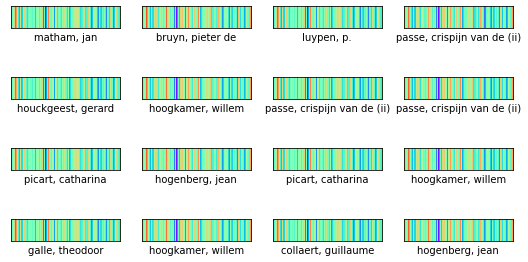

In [ ]:
plot_aggregates(aggregate_vectors,artistnames,n=4)

In [ ]:
# Query Image Removal Function
def query_image_remover(qi_vec, avg_vec, artnum):
    new_vec = (tf.math.subtract(avg_vec,  qi_vec * (1/artnum)) * (artnum/(artnum-1)))
    return new_vec